# Optimization of TensorFlow models with TensorRT

In this notebook you will learn how to use the TensorFlow integration for TensorRT (also known as TF-TRT) to increase inference performance.

For more information and detail about [TF-TRT](https://blog.tensorflow.org/2019/06/high-performance-inference-with-TensorRT.html)

## Objectives

By the time you complete this workshop you will be able to:

- Optimize several deep learning models with TF-TRT
- Describe how TF-TRT optimizes models
- Use TF-TRT to optimize models at FP32 precision
- Use TF-TRT to optimize models at FP16 precision
- Perform calibration for INT8 precision optimization
- Perform experiments to understand the impact of conversion parameters on optimization

In [0]:
from IPython.display import Image

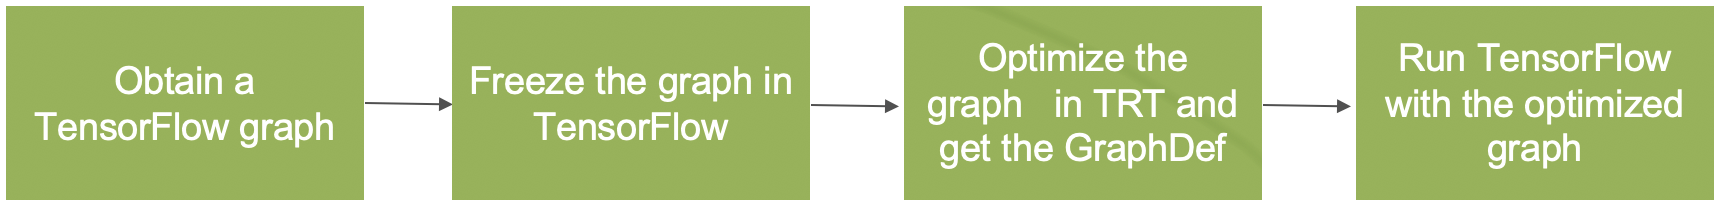

In [4]:
Image("images/pipeline.png")

## Contents

This workshop consists of several JupyterLab Notebooks.

- **A quick overview of how to work with thi Colaboratory environment**
- **Review inference with TF 2 and get familiar with helper functions used in this workshop**
- **Learn how TF-TRT optimizes models for faster inference**
- **Learn the syntax for performing optimization with TF-TRT**
- **Perform FP16 precision optimization** 
- **Learn how TF-TRT optimizes with INT8 precision** 
- **Perform data calibration and optimize with INT8 precision** 
- **Experiment with the impact of the minimum segment size conversion parameter, and optimize additional models** 

## Check GPU

In [5]:
!nvidia-smi

Sun Apr 19 19:35:41 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    34W / 149W |      0MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

As you can see almost no GPU memory is being used right now, and, there are no active processes utilizing the GPUs. Throughout the lab you can use this command to keep an eye on memory usage.

# Naive Malaria Inference with TensorFlow 2

In this step we will run inference with TensorFlow 2, without the help of TF-TRT. In doing so we will establish baselines for image throughput and prediction accuracy which we can use as we optimze with TF-TRT.

## Objectives

By the time you complete this notebook you should be able to:

- Use provided helper functions to load images, batch input, make and benchmark predictions, and display prediction information
- Obtain a baseline for naive Malaria TensorFlow 2 inference

## Imports

In [2]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
print('Tensorflow version',tf.__version__)

from tensorflow.keras import layers, models
from tensorflow.python.saved_model import tag_constants

Tensorflow version 2.2.0-rc3


Throughout the notebook we will make extensive use of helper functions defined in `./lab_helpers.py`.

In [0]:
from trt_helpers import (
    get_images, batch_input, predict_and_benchmark_throughput_from_saved,
    display_prediction_info, load_tf_saved_model, convert_to_trt_graph_and_save
)

## Create Batched Input

Using **batch inference** to send many images to the GPU at once promotes parallel processing and improve throughput.

### Get Images

The `get_images` helper function will use Keras to load the number of images specified, returning for each image the image itself in PIL format, and its file path, which we will need later to load and view the images from within these notebooks.

In [0]:
number_of_images = 32
images = get_images(number_of_images)

In [5]:
images[:1]

[(<PIL.Image.Image image mode=RGB size=130x130 at 0x7F8957E450B8>,
  './test/C39P4thinF_original_IMG_20150622_110115_cell_116.png')]

### Batch Input

The `batch_input` helper function takes a list of images with their paths, as returned by `get_images`, and returns a tensor with the the images preprocessed.

In [0]:
batched_input = batch_input(images)

In [7]:
type(batched_input)

tensorflow.python.framework.ops.EagerTensor

In [8]:
batched_input.shape

TensorShape([32, 130, 130, 3])

## Get Baseline for Prediction Throughput and Accuracy

The following will serve as a baseline for prediction throughput and accuracy.

## Load Model

Here we load a previously-saved ResnetV2 model.

In [9]:
saved_model_loaded = load_tf_saved_model('malaria_model')

Loading saved model malaria_model...


In [0]:
infer = saved_model_loaded.signatures['serving_default']

### Make Prediction and Get Throughput

Now we perform inference with the optimized graph, and after a warmup, time and calculate throughput.

The helper functoin `predict_and_benchmark_throughput_from_saved` will use the passed in model to perform predictions on the passed in batched input over a number of runs. It measures and reports throughput, as well as time for ranges of runs.

Because, due to GPU initialization operations, we do not want to profile against initial inference, we can set a number of warmup runs to perform prior to benchmarking.

`predict_and_benchmark_throughput_from_saved` returns the predictions for all images for all runs, after the warmup.

In [11]:
all_preds = predict_and_benchmark_throughput_from_saved(batched_input, infer, N_warmup_run=10, N_run=10)

Steps 0-50 average:  4.2ms
Throughput: 15885 images/s


**Make note of the *Throughput* value for this naive TensorFlow 2 inference.**

### Observe Accuracy

In [0]:
last_preds_run = all_preds[0]

./test/C39P4thinF_original_IMG_20150622_110115_cell_116.png


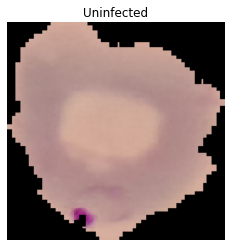

./test/C39P4thinF_original_IMG_20150622_110115_cell_133.png


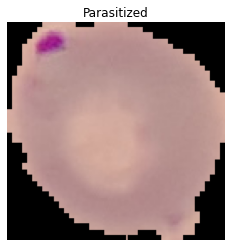

./test/C39P4thinF_original_IMG_20150622_105335_cell_13.png


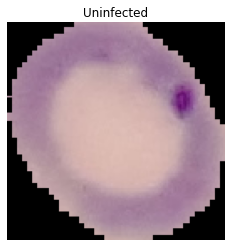

./test/C39P4thinF_original_IMG_20150622_105102_cell_84.png


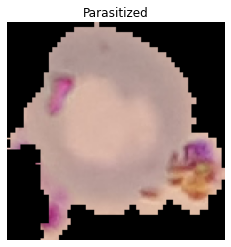

./test/C39P4thinF_original_IMG_20150622_105102_cell_104.png


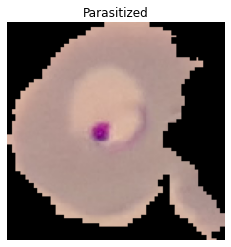

./test/C5NThinF_IMG_20150609_122108_cell_163.png


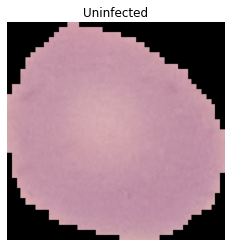

./test/C3thin_original_IMG_20150608_163029_cell_220.png


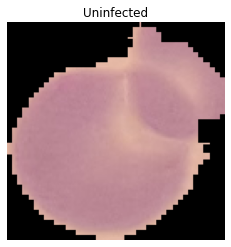

./test/C5NThinF_IMG_20150609_122227_cell_72.png


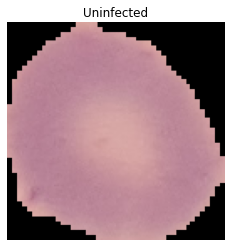

./test/C2NThinF_IMG_20150604_115238_cell_126.png


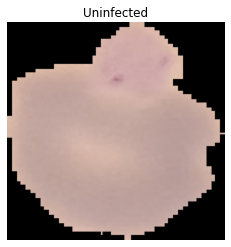

./test/C4thin_original_IMG_20150608_170016_cell_31.png


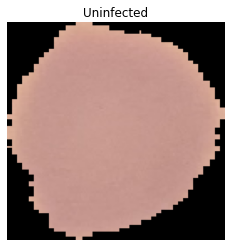

./test/C39P4thinF_original_IMG_20150622_105253_cell_92.png


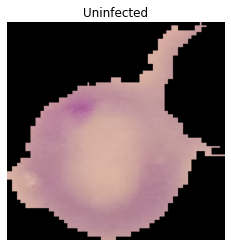

./test/C39P4thinF_original_IMG_20150622_105102_cell_100.png


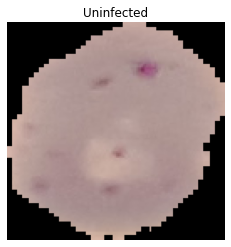

./test/C39P4thinF_original_IMG_20150622_105253_cell_102.png


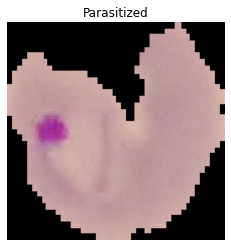

./test/C5NThinF_IMG_20150609_122034_cell_171.png


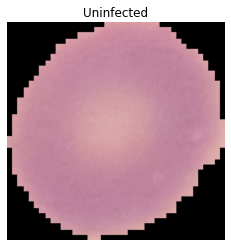

./test/C39P4thinF_original_IMG_20150622_105253_cell_104.png


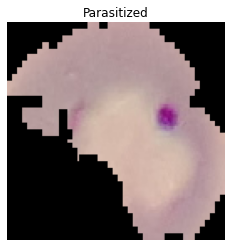

./test/C39P4thinF_original_IMG_20150622_105803_cell_98.png


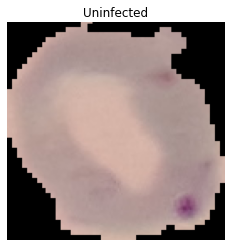

./test/C3thin_original_IMG_20150608_163002_cell_195.png


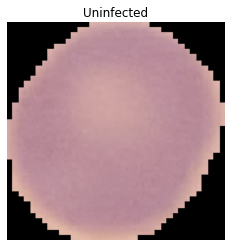

./test/C39P4thinF_original_IMG_20150622_105253_cell_91.png


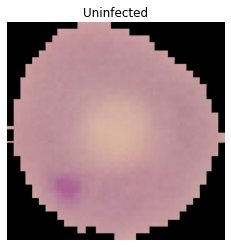

./test/C5NThinF_IMG_20150609_122020_cell_48.png


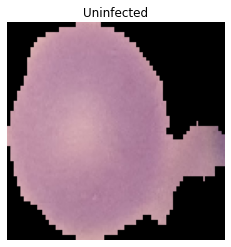

./test/C3thin_original_IMG_20150608_162835_cell_101.png


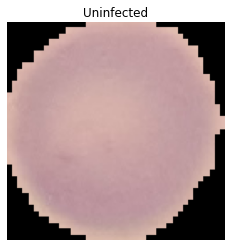

./test/C3thin_original_IMG_20150608_162835_cell_8.png


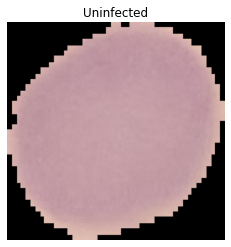

./test/C5NThinF_IMG_20150609_122020_cell_37.png


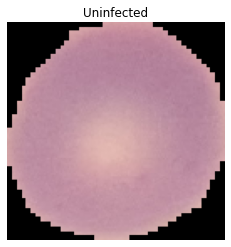

./test/C39P4thinF_original_IMG_20150622_110115_cell_130.png


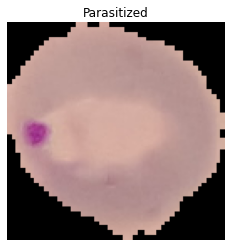

./test/C4thin_original_IMG_20150608_165540_cell_50.png


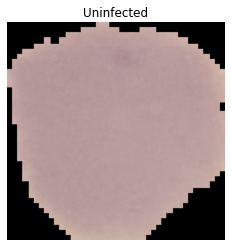

./test/C39P4thinF_original_IMG_20150622_110115_cell_128.png


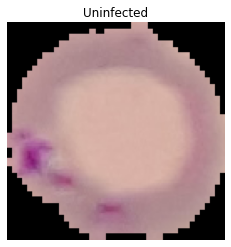

./test/C39P4thinF_original_IMG_20150622_105335_cell_23.png


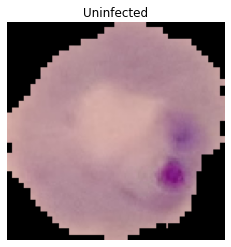

./test/C3thin_original_IMG_20150608_163029_cell_57.png


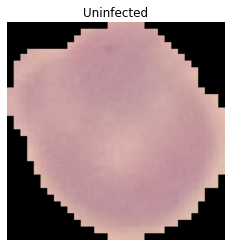

./test/C39P4thinF_original_IMG_20150622_110352_cell_113.png


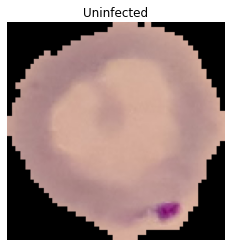

./test/C2NThinF_IMG_20150604_114815_cell_235.png


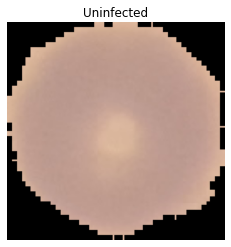

./test/C39P4thinF_original_IMG_20150622_110352_cell_94.png


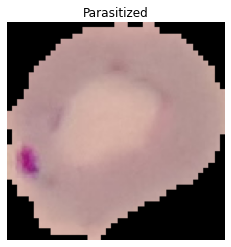

./test/C39P4thinF_original_IMG_20150622_105253_cell_97.png


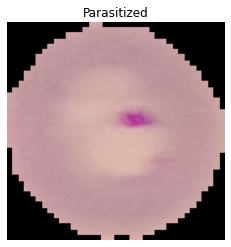

./test/C2NThinF_IMG_20150604_114815_cell_242.png


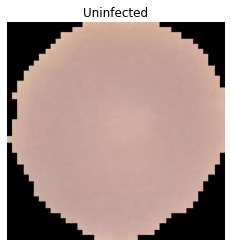

In [13]:
display_prediction_info(last_preds_run, images)

## Next

In the next notebook you will learn how TF-TRT optimizes saved models.

# TF-TRT Inference

This notebook gives a high-level description of how TF-TRT optimizes graphs, and also, how to code this optimization. In the next notebook you will use this knowledge to code a TF-TRT optimization.

## Objectives

By the time you complete this notebook you will be able to:

- Describe how TF-TRT performs graph optimization
- Describe how to use `TrtGraphConverterV2` to code TF-TRT graph optimizations

## Network Transformation

TF-TRT performs several important transformations and optimizations to the neural network graph. First, layers with unused outputs are eliminated to avoid unnecessary computation. Next, where possible, convolution, bias, and ReLU layers are fused to form a single layer. *Figure 1* shows a typical convolutional network before optimization:

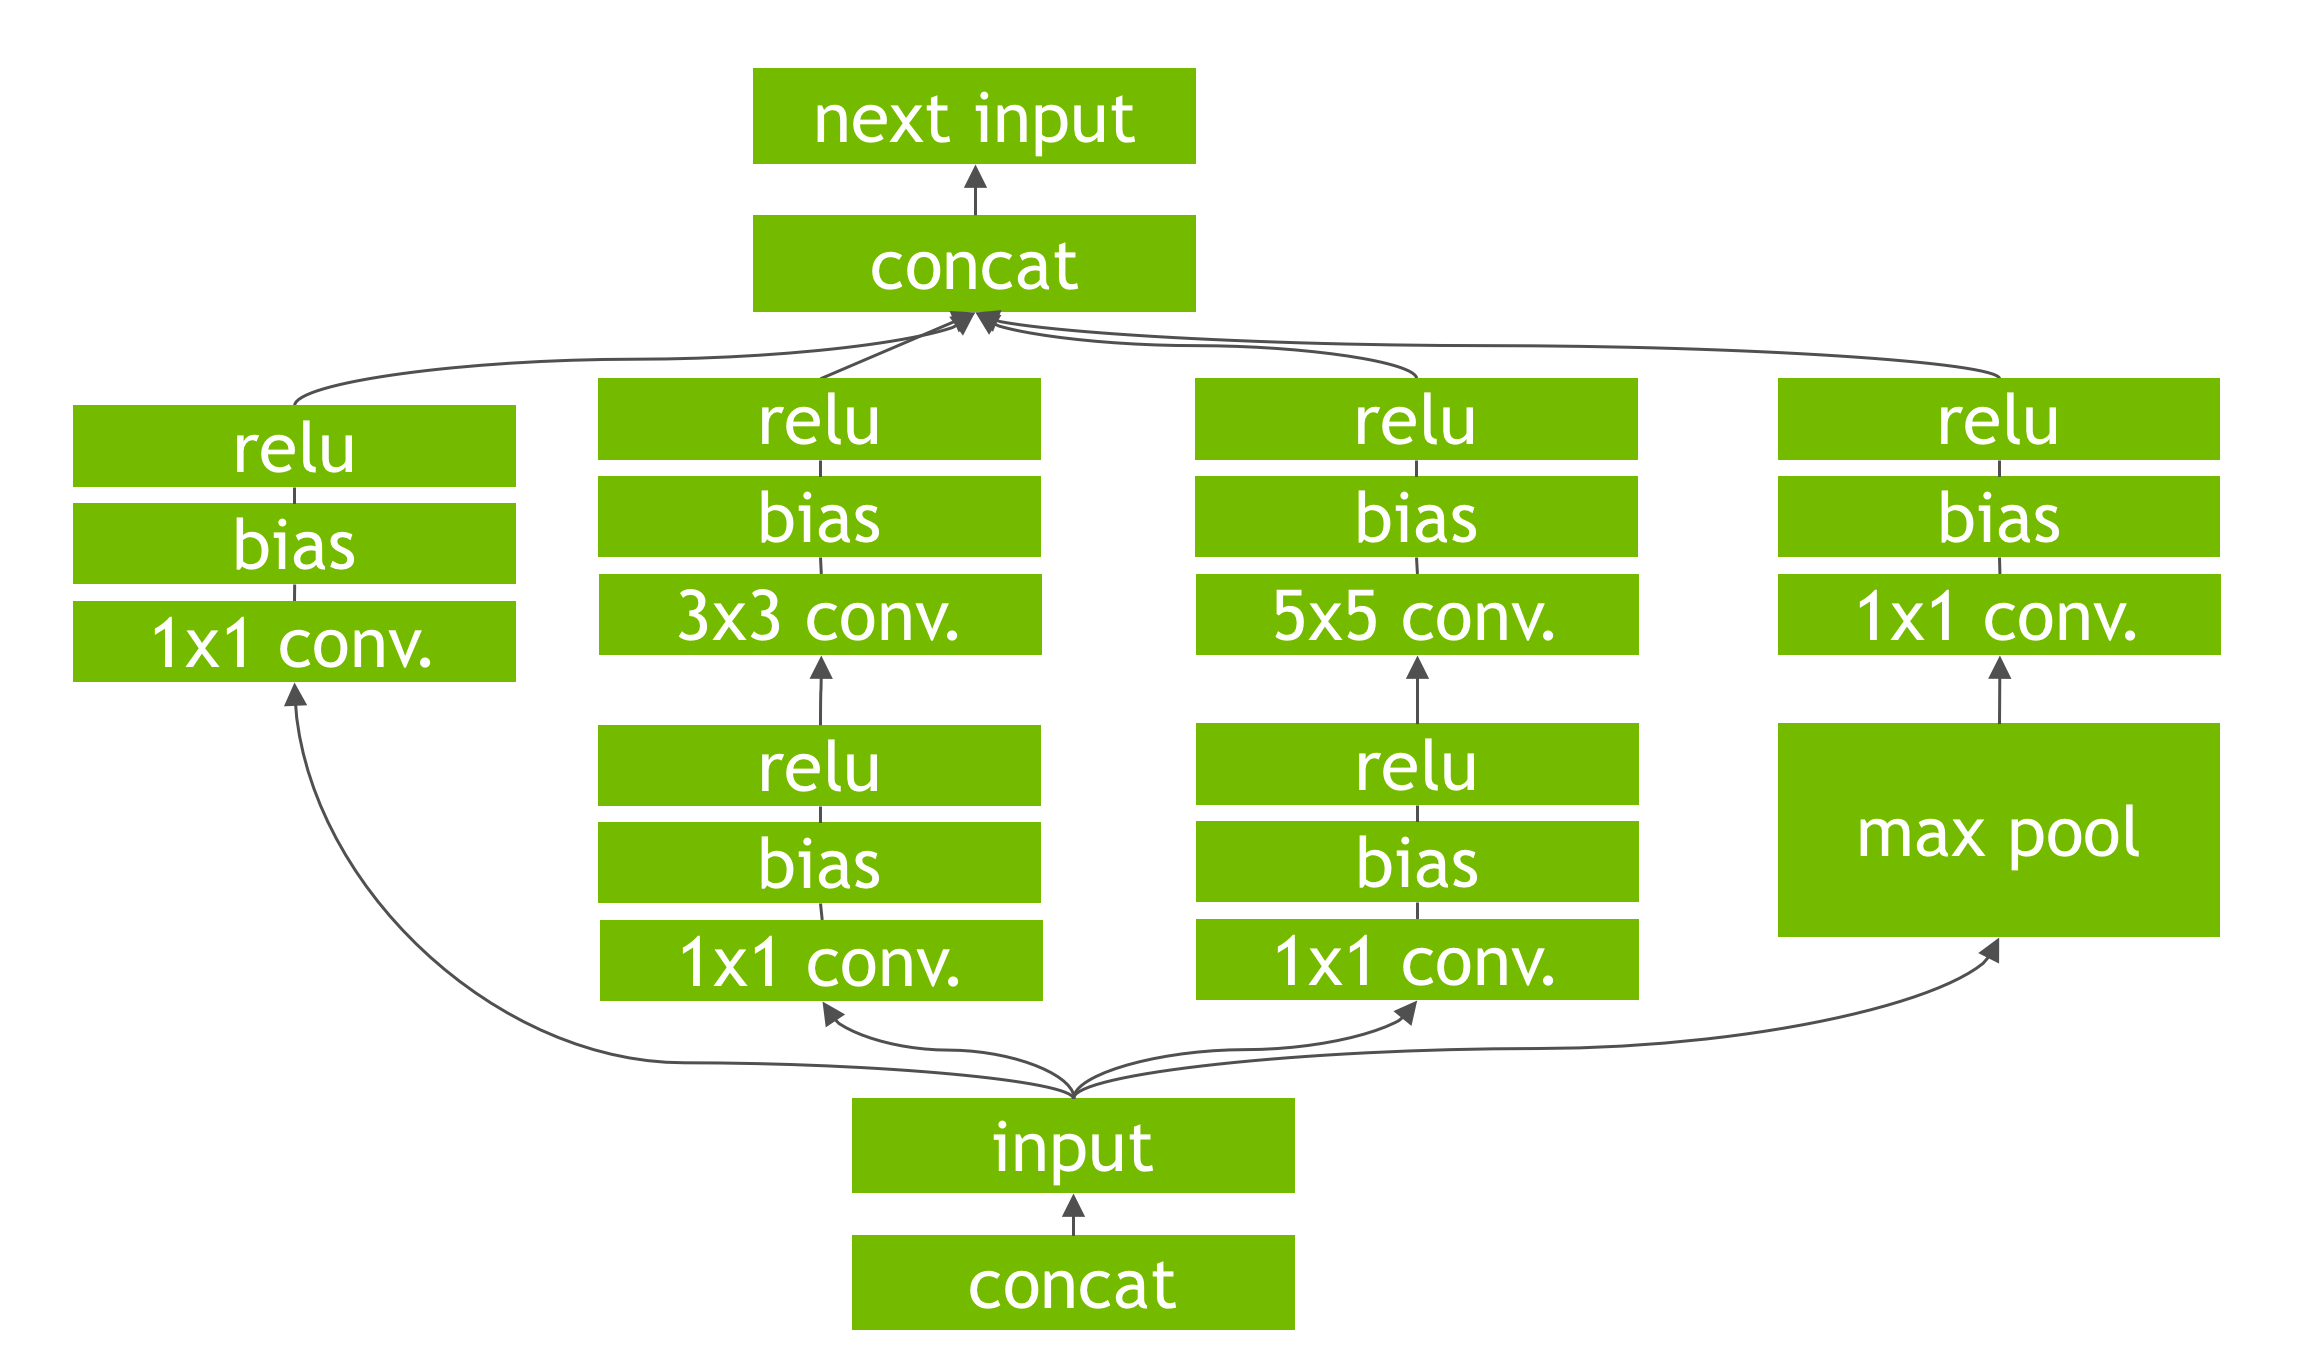

In [14]:
Image("images/network_optimization.png")

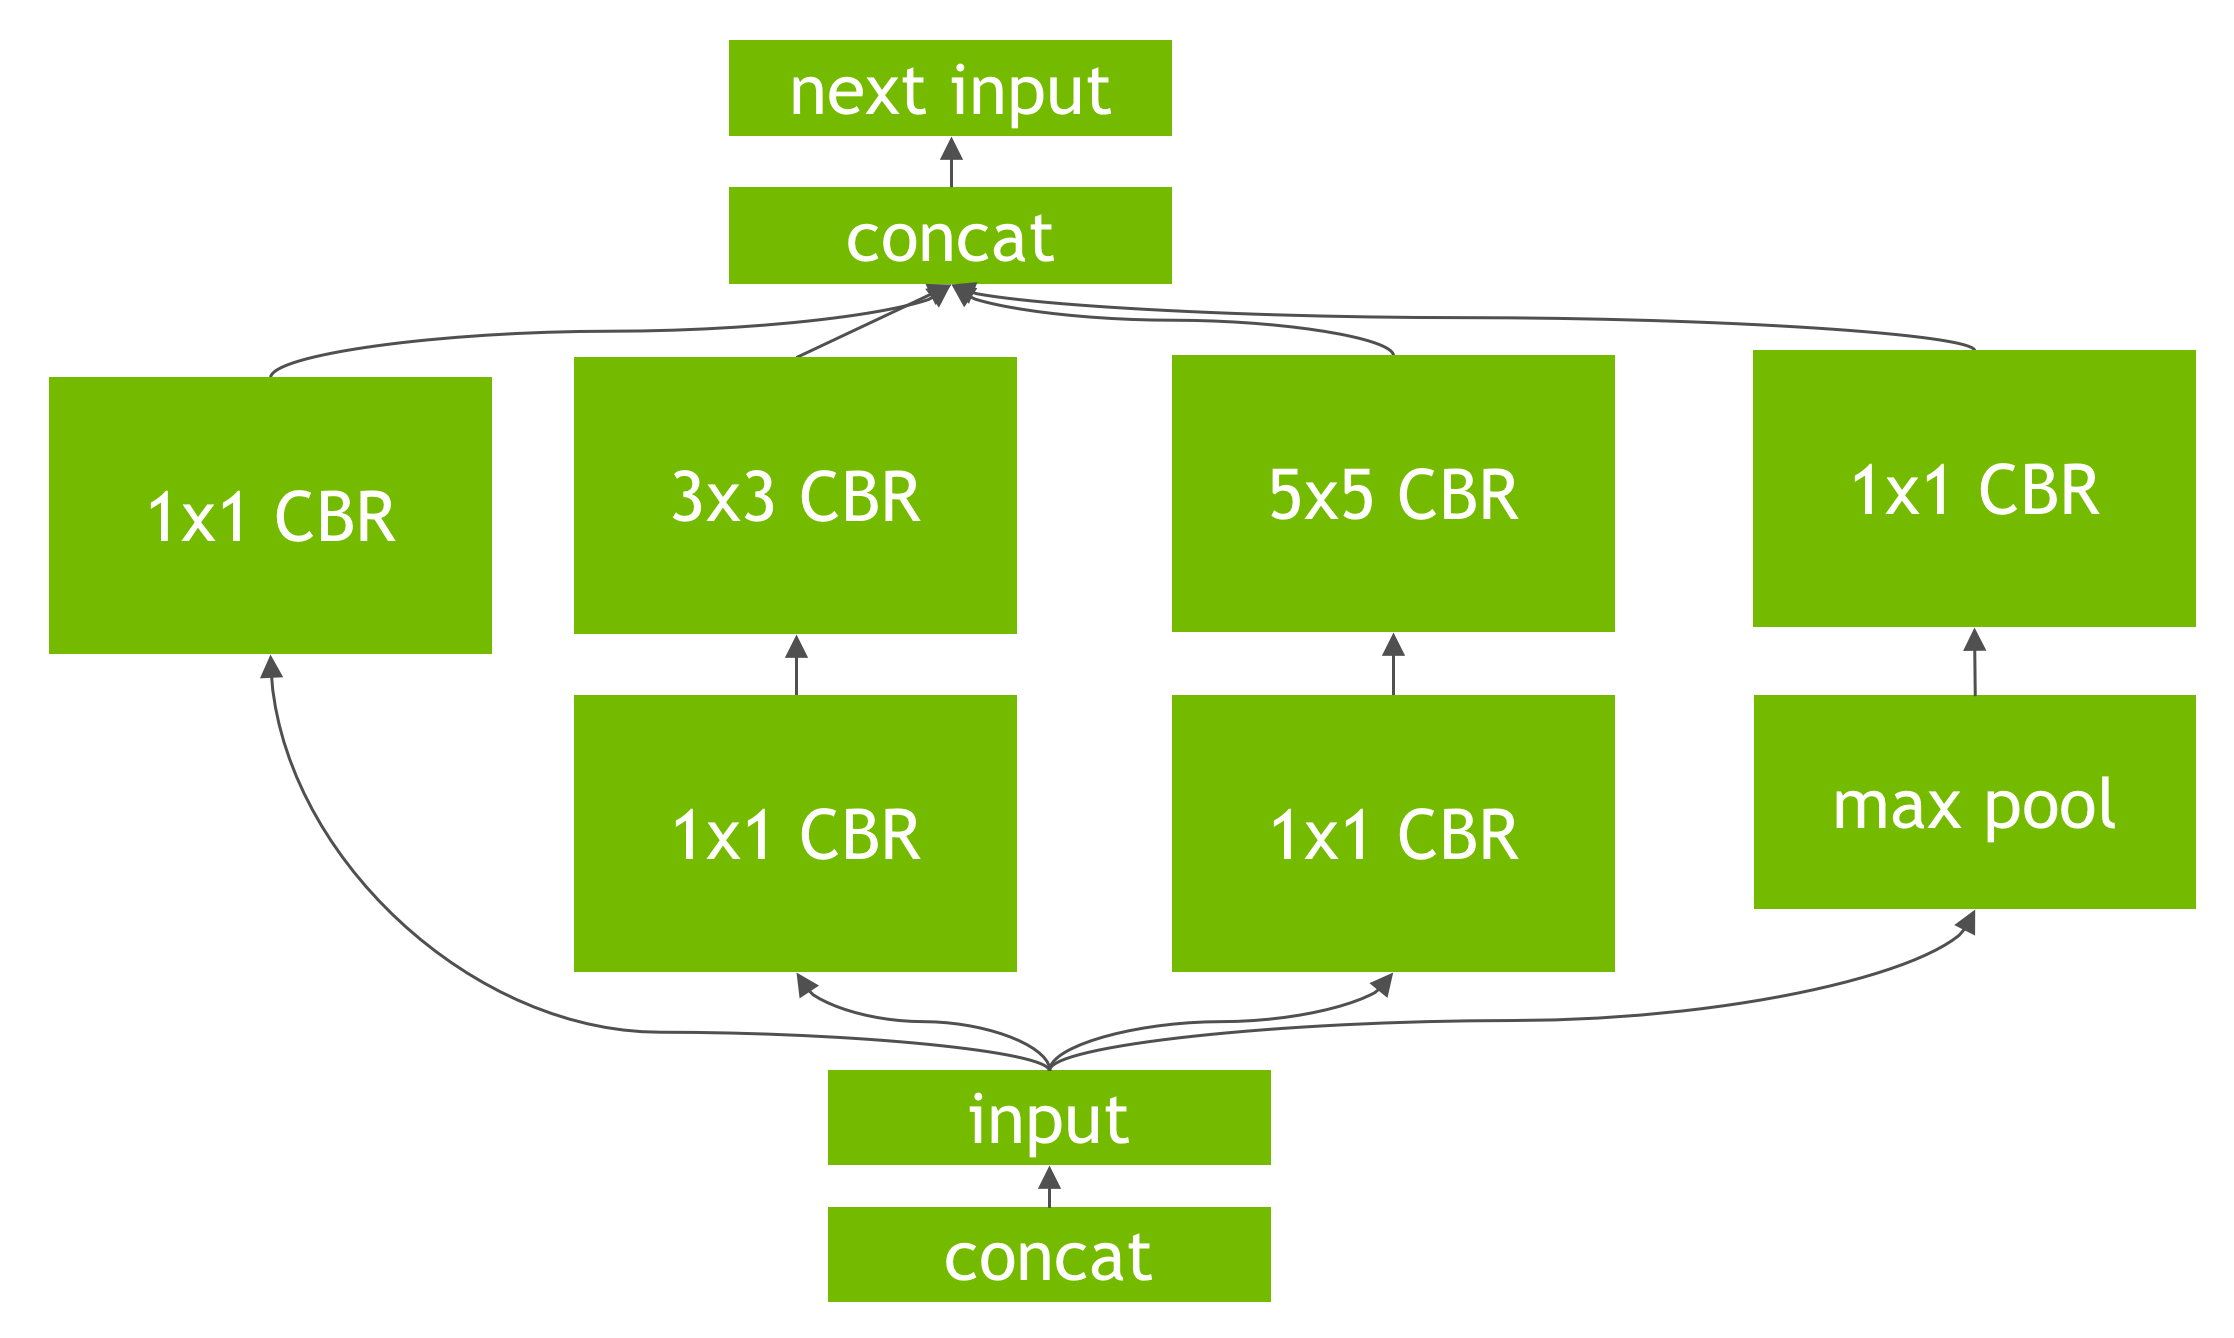

In [15]:
Image("images/network_vertical_fusion.png")

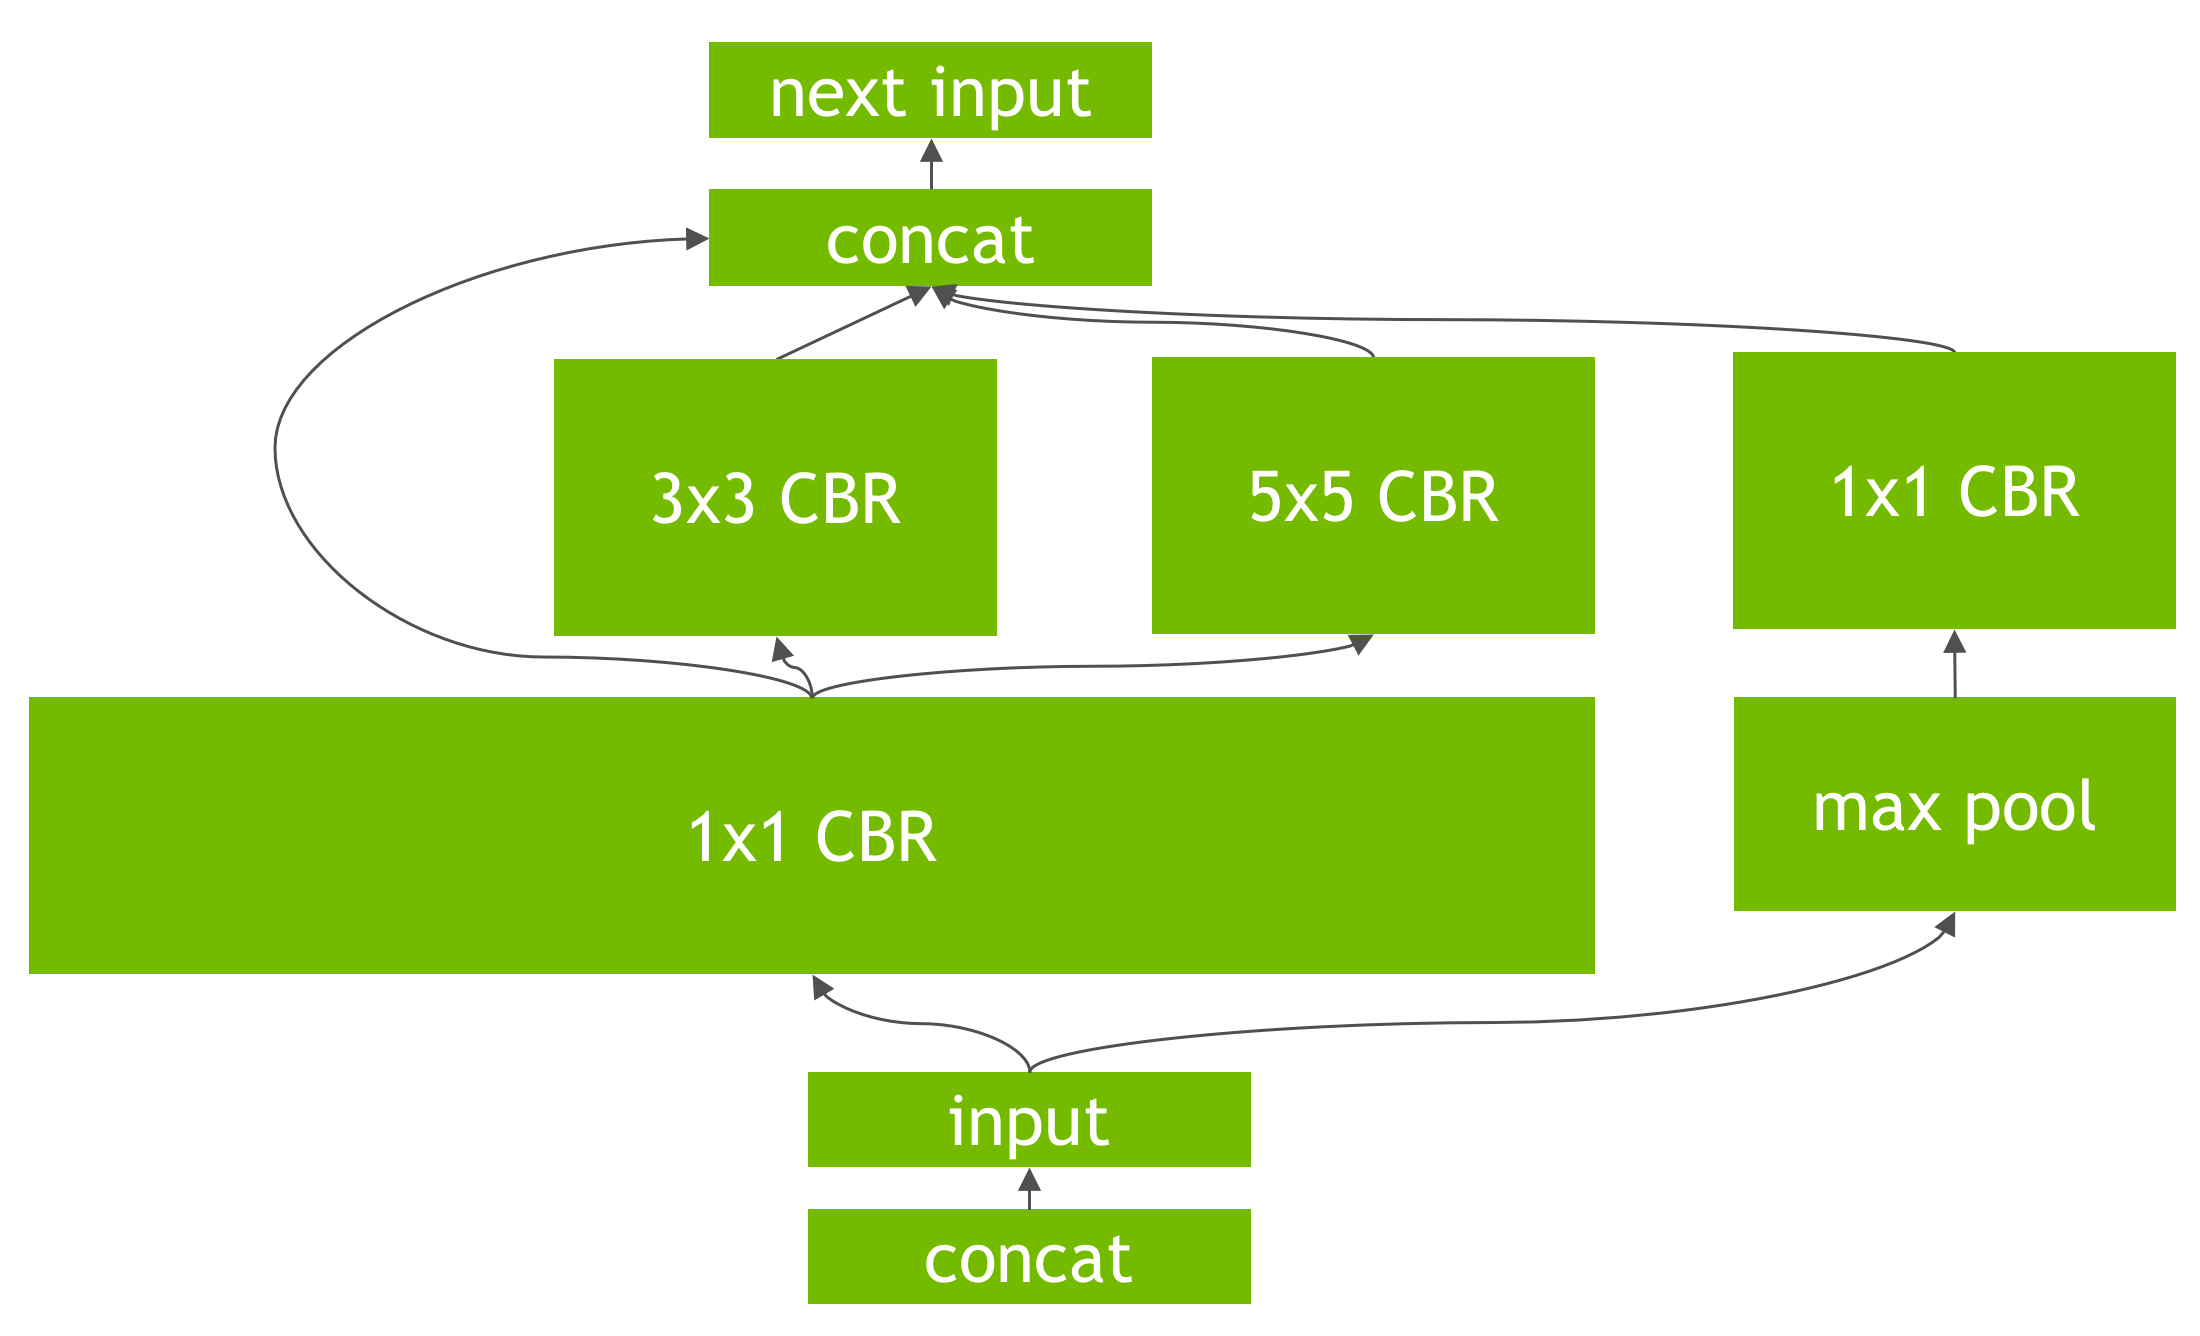

In [16]:
Image("images/network_horizontal_fusion.png")

When optimizing a TensorFlow model, TF-TRT can optimize either a subgraph or the entire graph definition. This capability allows the optimization procedure to be applied to the graph where possible and skip the non-supported graph segments. As a result, if the existing model contains a non-supported layer or operation, TensorFlow can still optimize the graph. 

Please see the [TF-TRT User Guide](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/index.html#supported-ops) for a full list of supported operators.

## TF-TRT Workflow

Below, you can see a typical workflow of TF-TRT:

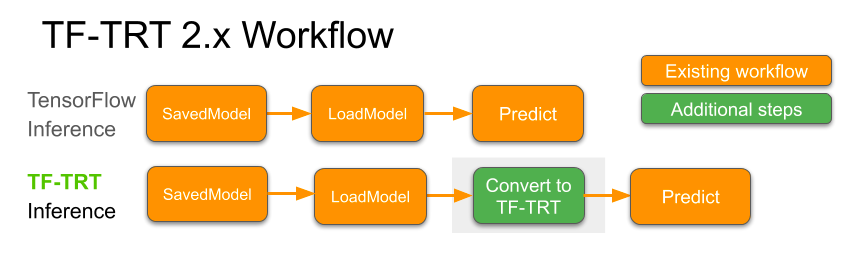

In [17]:
Image("images/inference_process_fp.png")

We now turn to the syntax for this one additional *Convert to TF-TRT* step.

## Graph Conversion

To perform graph conversion, we use `TrtGraphConverterV2`, passing it the directory of a saved model, and any updates we wish to make to its conversion parameters.

```python
from tensorflow.python.compiler.tensorrt import trt_convert as trt

trt.TrtGraphConverterV2(
    input_saved_model_dir=None,
    conversion_params=TrtConversionParams(precision_mode='FP32',
                                          max_batch_size=1
                                          minimum_segment_size=3,
                                          max_workspace_size_bytes=1073741824,
                                          use_calibration=True,
                                          maximum_cached_engines=1,
                                          is_dynamic_op=True,
                                          rewriter_config_template=None,
                                         )
```

### Conversion Parameters

Another transformation is horizontal layer fusion, or layer aggregation, along with the required division of aggregated layers to their respective outputs, as Figure 3 shows.

Horizontal layer fusion improves performance by combining layers that take the same source tensor and apply the same operations with similar parameters, resulting in a single larger layer for higher computational efficiency. The example in Figure 3 shows the combination of 3 1×1 CBR layers from Figure 2 that take the same input into a single larger 1×1 CBR layer. Note that the output of this layer must be disaggregated to feed into the different subsequent layers from the original input graph.

Here is additional information about the most frequently adjusted conversion parameters, all of which you will have an opportunity to code with in later exercises.

* __precision_mode__: This parameter sets the precision mode; which can be one of FP32, FP16, or INT8. Precision lower than FP32, meaning FP16 and INT8, would improve the performance of inference. The FP16 mode uses Tensor Cores or half precision hardware instructions, if possible. The INT8 precision mode uses integer hardware instructions.

* __max_batch_size__: This parameter is the maximum batch size for which TF-TRT will optimize. At runtime, a smaller batch size may be chosen, but, not a larger one.

* __minimum_segment_size__: This parameter determines the minimum number of TensorFlow nodes in a TF-TRT engine, which means the TensorFlow subgraphs that have fewer nodes than this number will not be converted to TensorRT. Therefore, in general, smaller numbers such as 5 are preferred. This can also be used to change the minimum number of nodes in the optimized INT8 engines to change the final optimized graph to fine tune result accuracy.

* __max_workspace_size_bytes__: TF-TRT operators often require temporary workspace. This parameter limits the maximum size that any layer in the network can use. If insufficient scratch is provided, it is possible that TF-TRT may not be able to find an implementation for a given layer.

For more information, please refer to the [TF-TRT User Guide](https://docs.nvidia.com/deeplearning/frameworks/tf-trt-user-guide/).

## Next

In the next notebook we will demonstrate a TF-TRT conversion using Float32 precision.

# Convert to TF-TRT Float32 and Float16

In this notebook we will demonstrate how to convert a TensorFlow saved model into a TF-TRT optimized graph using Float32 and Float16 precision. We will use the optimized graph to make predictions and will benchmark its performance. In the next notebook, you will be asked to make your first optimized TF-TRT graph using Float16 precision.

## Objectives

By the end of this notebook you will be able to:

- Convert a saved TensorFlow model into an optimized TF-TRT graph with Float32 precision

## Make Conversion

`convert_to_trt_graph_and_save` expects the directory of a saved model, which it will convert to an optimized TF-TRT graph with Float32 precision, and then save. Please read the comments for this function.

In [18]:
convert_to_trt_graph_and_save(precision_mode='float32', input_saved_model_dir='malaria_model')

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
Converting malaria_model to TF-TRT graph precision mode FP32...
Saving converted model to malaria_model_TFTRT_FP32...
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: malaria_model_TFTRT_FP32/assets
Complete


In [19]:
convert_to_trt_graph_and_save(precision_mode='float16', input_saved_model_dir='malaria_model')

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
Converting malaria_model to TF-TRT graph precision mode FP16...
Saving converted model to malaria_model_TFTRT_FP16...
INFO:tensorflow:Assets written to: malaria_model_TFTRT_FP16/assets
Complete


## Benchmark TF-TRT Float32

Here we load the optimized TF model. Note that this is a TF saved model, as opposed to a Keras saved model. If you wish, refer to `lab_helpers.py` for details on the helper functions.

In [20]:
infer_FP32 = load_tf_saved_model('malaria_model_TFTRT_FP32')

Loading saved model malaria_model_TFTRT_FP32...


Now we perform inference with the optimized graph, and after a warmup, time and calculate throughput.

In [22]:
all_preds_fp32 = predict_and_benchmark_throughput_from_saved(batched_input, infer_FP32, N_warmup_run=10, N_run=10, model="quantized")

Steps 0-50 average: 14.9ms
Throughput: 2229 images/s


**Compare *Throughput* to the naive TF 2 inference perfomed earlier.**

Run this cell to view predictions, which you can use to compare to the naive TF 2 run. You should see very little difference in the accuracy of the predicitons.

./test/C39P4thinF_original_IMG_20150622_110115_cell_116.png


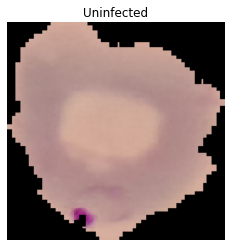

./test/C39P4thinF_original_IMG_20150622_110115_cell_133.png


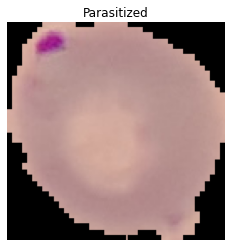

./test/C39P4thinF_original_IMG_20150622_105335_cell_13.png


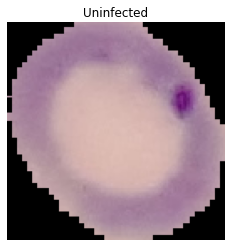

./test/C39P4thinF_original_IMG_20150622_105102_cell_84.png


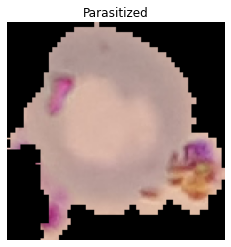

./test/C39P4thinF_original_IMG_20150622_105102_cell_104.png


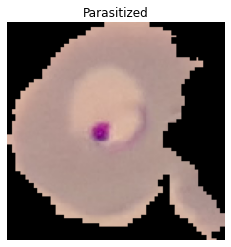

./test/C5NThinF_IMG_20150609_122108_cell_163.png


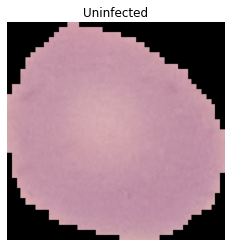

./test/C3thin_original_IMG_20150608_163029_cell_220.png


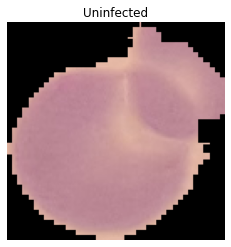

./test/C5NThinF_IMG_20150609_122227_cell_72.png


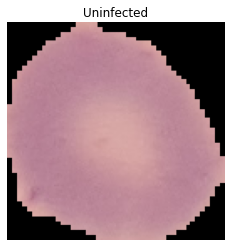

./test/C2NThinF_IMG_20150604_115238_cell_126.png


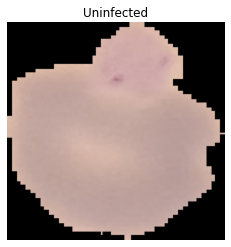

./test/C4thin_original_IMG_20150608_170016_cell_31.png


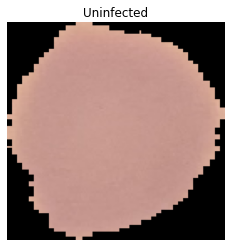

./test/C39P4thinF_original_IMG_20150622_105253_cell_92.png


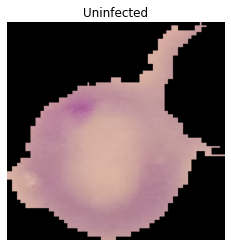

./test/C39P4thinF_original_IMG_20150622_105102_cell_100.png


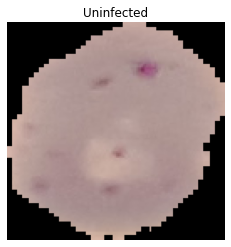

./test/C39P4thinF_original_IMG_20150622_105253_cell_102.png


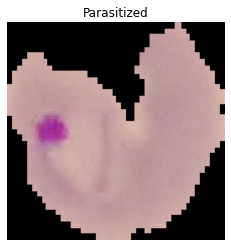

./test/C5NThinF_IMG_20150609_122034_cell_171.png


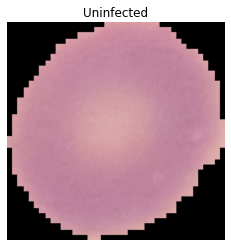

./test/C39P4thinF_original_IMG_20150622_105253_cell_104.png


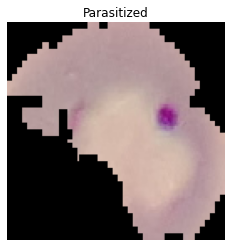

./test/C39P4thinF_original_IMG_20150622_105803_cell_98.png


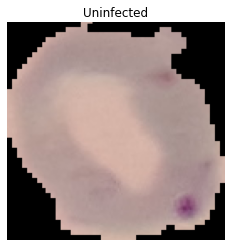

./test/C3thin_original_IMG_20150608_163002_cell_195.png


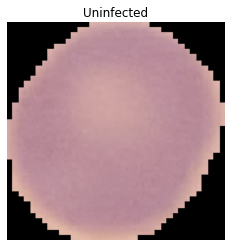

./test/C39P4thinF_original_IMG_20150622_105253_cell_91.png


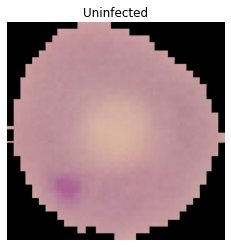

./test/C5NThinF_IMG_20150609_122020_cell_48.png


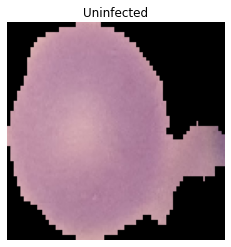

./test/C3thin_original_IMG_20150608_162835_cell_101.png


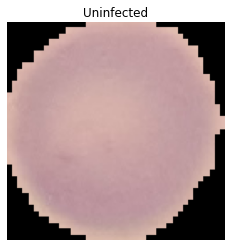

./test/C3thin_original_IMG_20150608_162835_cell_8.png


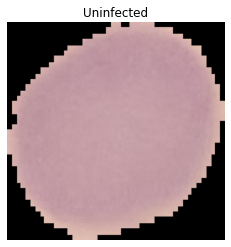

./test/C5NThinF_IMG_20150609_122020_cell_37.png


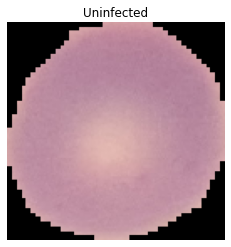

./test/C39P4thinF_original_IMG_20150622_110115_cell_130.png


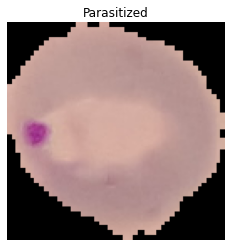

./test/C4thin_original_IMG_20150608_165540_cell_50.png


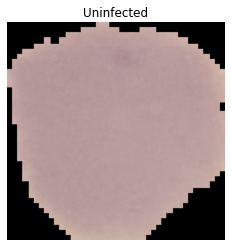

./test/C39P4thinF_original_IMG_20150622_110115_cell_128.png


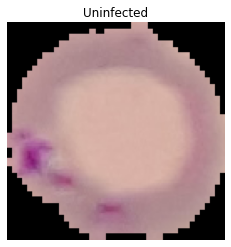

./test/C39P4thinF_original_IMG_20150622_105335_cell_23.png


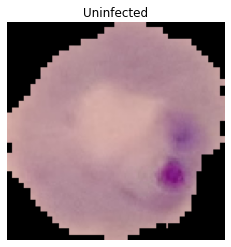

./test/C3thin_original_IMG_20150608_163029_cell_57.png


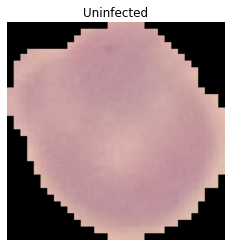

./test/C39P4thinF_original_IMG_20150622_110352_cell_113.png


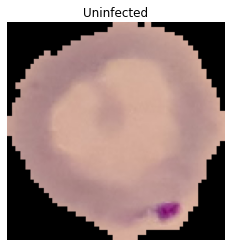

./test/C2NThinF_IMG_20150604_114815_cell_235.png


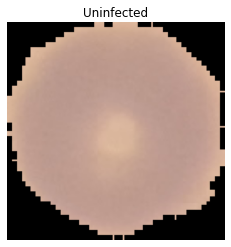

./test/C39P4thinF_original_IMG_20150622_110352_cell_94.png


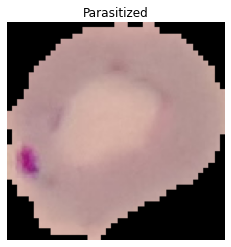

./test/C39P4thinF_original_IMG_20150622_105253_cell_97.png


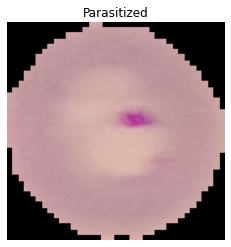

./test/C2NThinF_IMG_20150604_114815_cell_242.png


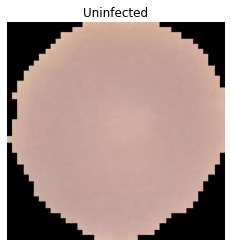

In [23]:
last_run_preds_fp32 = all_preds_fp32[0]
last_run_preds_fp32 = tf.make_tensor_proto(last_run_preds_fp32)
last_run_preds_fp32 = tf.make_ndarray(last_run_preds_fp32)
display_prediction_info(last_run_preds_fp32, images)

In the next notebook, you will be asked to make your first optimized TF-TRT graph using Float16 precision.

## Benchmark TF-TRT Float16

Load the optimized TF model.

In [24]:
infer_fp16 = load_tf_saved_model('malaria_model_TFTRT_FP16')

Loading saved model malaria_model_TFTRT_FP16...


Perform inference with the optimized graph, and after a warmup, time and calculate throughput.

In [25]:
all_preds_fp16 = predict_and_benchmark_throughput_from_saved(batched_input, infer_fp16, N_warmup_run=10, N_run=10, model="quantized")

Steps 0-50 average: 14.5ms
Throughput: 2281 images/s


Run this cell to view predictions, which you can use for comparison.

./test/C39P4thinF_original_IMG_20150622_110115_cell_116.png


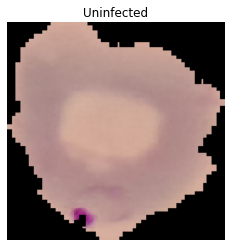

./test/C39P4thinF_original_IMG_20150622_110115_cell_133.png


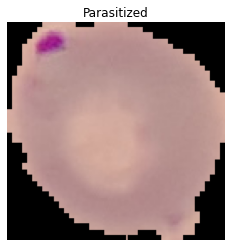

./test/C39P4thinF_original_IMG_20150622_105335_cell_13.png


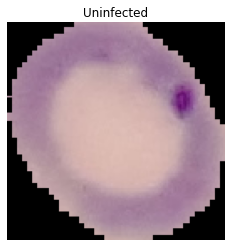

./test/C39P4thinF_original_IMG_20150622_105102_cell_84.png


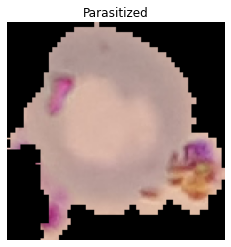

./test/C39P4thinF_original_IMG_20150622_105102_cell_104.png


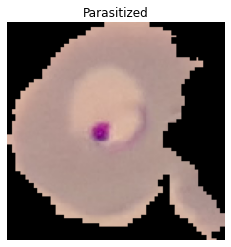

./test/C5NThinF_IMG_20150609_122108_cell_163.png


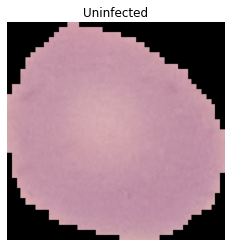

./test/C3thin_original_IMG_20150608_163029_cell_220.png


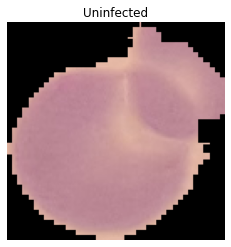

./test/C5NThinF_IMG_20150609_122227_cell_72.png


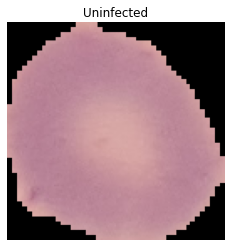

./test/C2NThinF_IMG_20150604_115238_cell_126.png


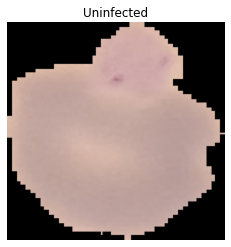

./test/C4thin_original_IMG_20150608_170016_cell_31.png


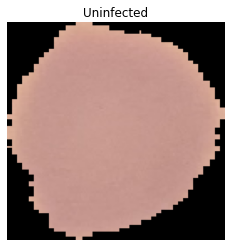

./test/C39P4thinF_original_IMG_20150622_105253_cell_92.png


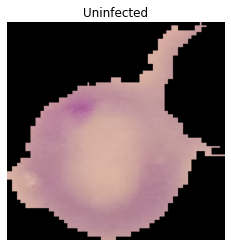

./test/C39P4thinF_original_IMG_20150622_105102_cell_100.png


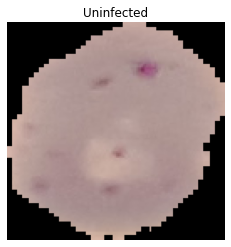

./test/C39P4thinF_original_IMG_20150622_105253_cell_102.png


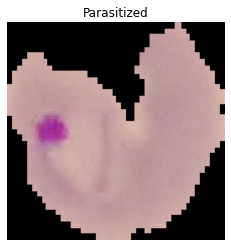

./test/C5NThinF_IMG_20150609_122034_cell_171.png


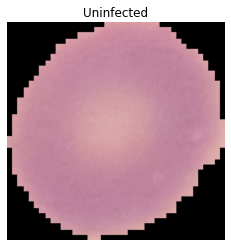

./test/C39P4thinF_original_IMG_20150622_105253_cell_104.png


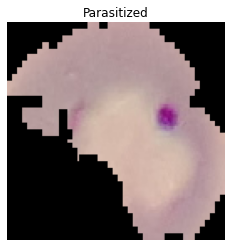

./test/C39P4thinF_original_IMG_20150622_105803_cell_98.png


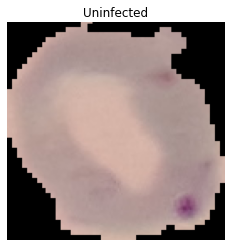

./test/C3thin_original_IMG_20150608_163002_cell_195.png


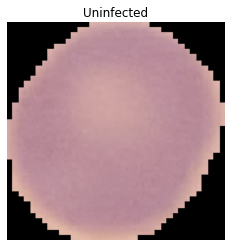

./test/C39P4thinF_original_IMG_20150622_105253_cell_91.png


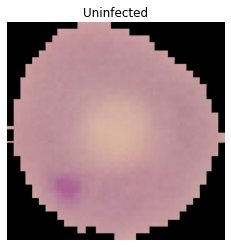

./test/C5NThinF_IMG_20150609_122020_cell_48.png


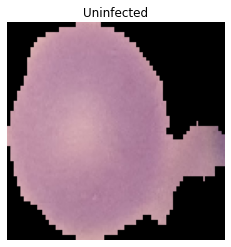

./test/C3thin_original_IMG_20150608_162835_cell_101.png


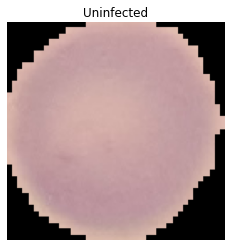

./test/C3thin_original_IMG_20150608_162835_cell_8.png


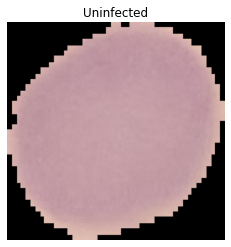

./test/C5NThinF_IMG_20150609_122020_cell_37.png


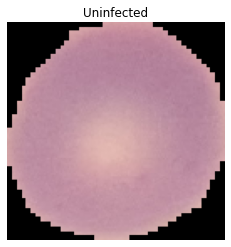

./test/C39P4thinF_original_IMG_20150622_110115_cell_130.png


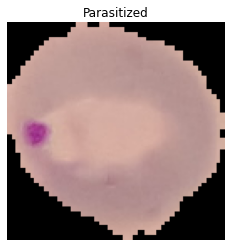

./test/C4thin_original_IMG_20150608_165540_cell_50.png


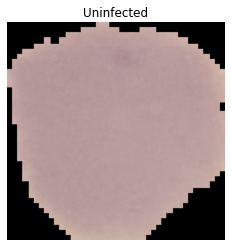

./test/C39P4thinF_original_IMG_20150622_110115_cell_128.png


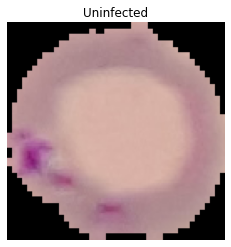

./test/C39P4thinF_original_IMG_20150622_105335_cell_23.png


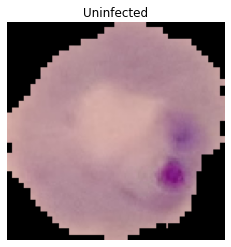

./test/C3thin_original_IMG_20150608_163029_cell_57.png


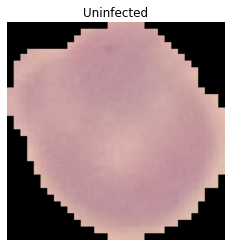

./test/C39P4thinF_original_IMG_20150622_110352_cell_113.png


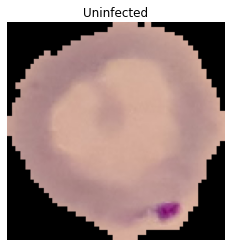

./test/C2NThinF_IMG_20150604_114815_cell_235.png


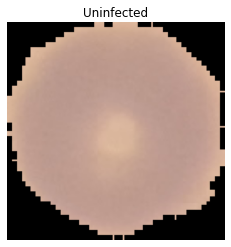

./test/C39P4thinF_original_IMG_20150622_110352_cell_94.png


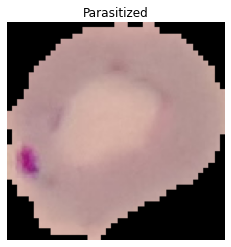

./test/C39P4thinF_original_IMG_20150622_105253_cell_97.png


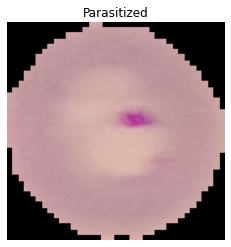

./test/C2NThinF_IMG_20150604_114815_cell_242.png


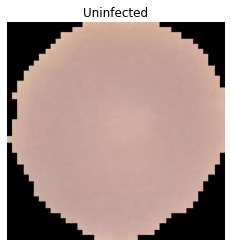

In [26]:
last_run_preds_fp16 = all_preds_fp32[0]
last_run_preds_fp16 = tf.make_tensor_proto(last_run_preds_fp16)
last_run_preds_fp16 = tf.make_ndarray(last_run_preds_fp16)
display_prediction_info(last_run_preds_fp16, images)

# INT8 Inference and Calibration

In this notebook we will discuss how TF-TRT is able to optimize to use Int8 precision.

## Benefits of Reduced Precision Inference

Typically, model training is performed using 32-bit floating point mathematics. Due to the backpropagation algorithm and weights updates, this high precision is necessary to allow for model convergence. Once trained, inference could be done in reduced precision (e.g. FP16) as the neural network architecture only requires a feed-forward network.

Reducing numerical precision allows for a smaller model with faster inferencing time, lower memory requirements, and more throughput.

Furthermore, recent NVIDIA GPUs are capable of executing 8-bit integer 4-element vector dot product instructions to accelerate deep neural network inference. 

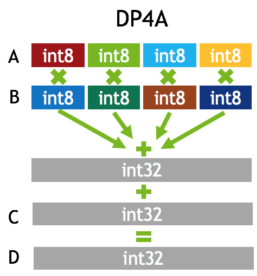

In [27]:
Image("images/dp4a-updated.png")

## Reduced Dynamic Range of INT8

While this new instruction provides faster computation, there is a significant challenge in representing weights and activations of deep neural networks in this reduced INT8 format. As *Table 1* shows, the dynamic range and granularity of representable values for INT8 is significantly limited compared to FP32 or FP16.

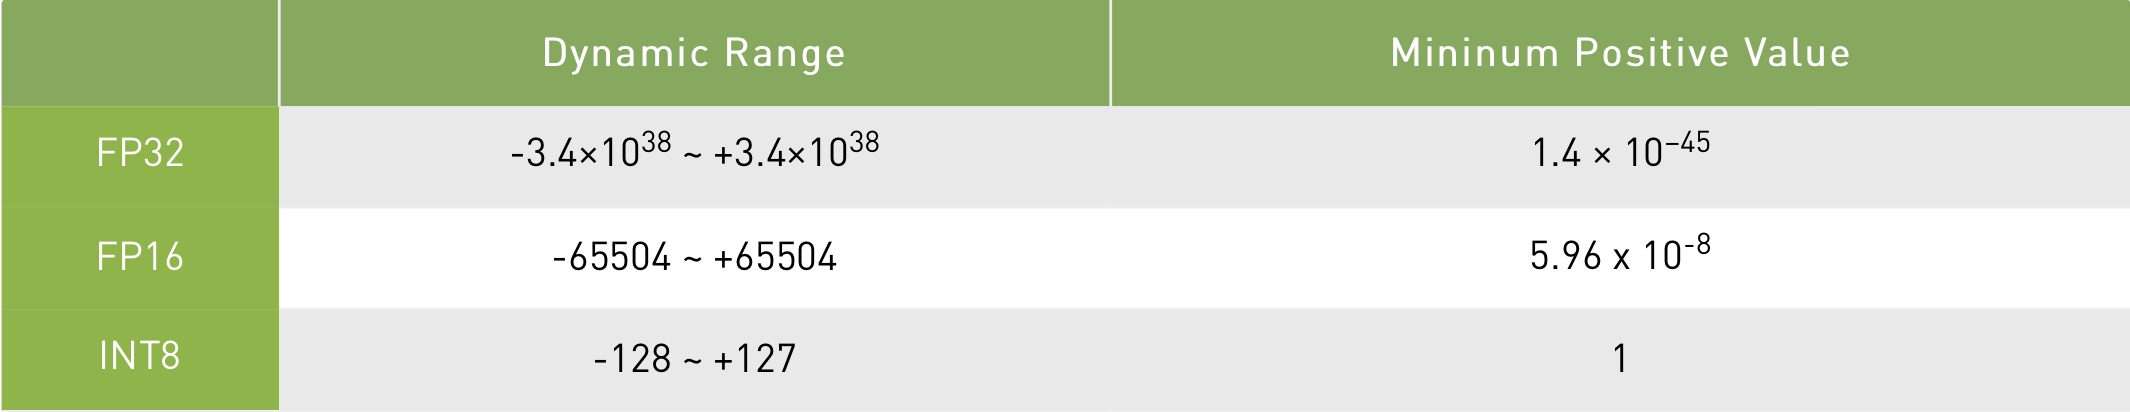

In [28]:
Image("images/table1.png")

## TF-TRT INT8 Quantization

You might be wondering how it is possible to take a model which operates in 32 bit floating point precision, where you can represent billions of different numbers, and reduce that to only 8 bit integers which can only represent 256 possible values.

The main reason is that, typically in deep learning, the values of weights and activations lie in very small ranges. So if we design our precious 8 bits to only represent this specific small range, we can usually maintain good accuracy while reducing the rounding error.

The main challenge is to find the correct dynamic range of the inputs. TF-TRT uses a calibration process that minimizes the information loss when approximating the FP32 network with a limited 8-bit integer representation. In the next notebook you will see how to perform this calibration process.

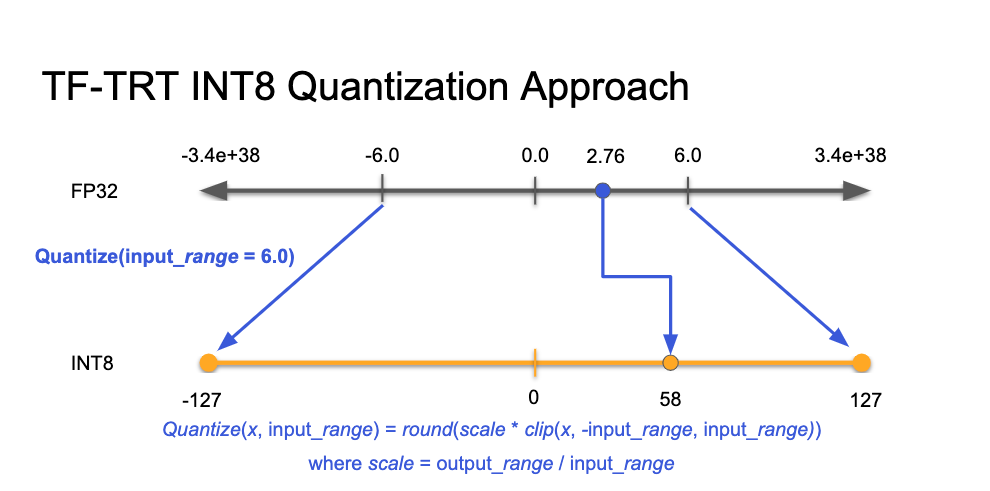

In [29]:
Image("images/int_8_approach.png")

## Calibration Dataset Considerations

When preparing the calibration dataset, you should capture the expected distribution of data in typical inference scenarios. You need to make sure that the calibration dataset covers all the expected scenarios, for example, clear weather, rainy day, night scenes, etc. When examining your own dataset, you should create a separate calibration dataset. The calibration dataset shouldn’t overlap with the training, validation or test datasets. 

For a much deeper technical dive on INT8 inference, you may watch the [8-Bit inference using TensorRT](http://on-demand.gputechconf.com/gtc/2017/video/s7310-szymon-migacz-8-bit-inference-with-tensorrt.mp4) presentation.

# Convert to TF-TRT INT8

In this notebook you will convert a TensorFlow saved model into a TF-TRT optimized graph using INT8 precision. You will use the optimized graph to make predictions and will benchmark its performance.

## Objectives

By the time you complete this notebook you wil be able to:

- Use TF-TRT to optimize a saved model with INT8 precision

## Converting to TF-TRT INT8

To perform INT8 optimization, we simply need to:

- Set `precision_mode` to `trt.TrtPrecisionMode.INT8`
- Pass a `calibration_input_fn` to `converter.convert`

### Calibration Input Function

`calibration_input_fn` should be a generator function that yields input data as a list or tuple.

You need to make sure that the calibration dataset covers all the expected scenarios, for example, clear weather, rainy day, night scenes, etc. When examining your own dataset, you should create a separate calibration dataset. The calibration dataset should not overlap with the training, validation, or test datasets.

For our simple example here, we will not take these extra steps and will simply pass in our `batched_input` as calibration data.

## Convert to TF-TRT INT8

In [30]:
convert_to_trt_graph_and_save(precision_mode='int8', input_saved_model_dir='malaria_model', calibration_data=batched_input)

INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
Converting malaria_model to TF-TRT graph precision mode INT8...
Saving converted model to malaria_model_TFTRT_INT8...
INFO:tensorflow:Assets written to: malaria_model_TFTRT_INT8/assets
Complete


## Benchmark TF-TRT INT8

Load the optimized TF model.

In [31]:
infer_int8 = load_tf_saved_model('malaria_model_TFTRT_INT8')

Loading saved model malaria_model_TFTRT_INT8...


Perform inference with the optimized graph, and after a warmup, time and calculate throughput.

In [32]:
all_preds_int8 = predict_and_benchmark_throughput_from_saved(batched_input, infer_int8, N_warmup_run=10, N_run=10, model="quantized")

Steps 0-50 average: 14.5ms
Throughput: 2276 images/s


Run this cell to view predictions, which you can use for comparison.

./test/C39P4thinF_original_IMG_20150622_110115_cell_116.png


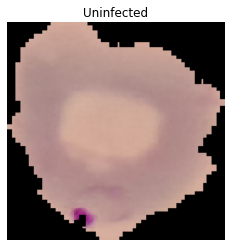

./test/C39P4thinF_original_IMG_20150622_110115_cell_133.png


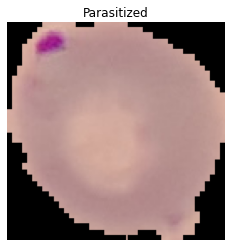

./test/C39P4thinF_original_IMG_20150622_105335_cell_13.png


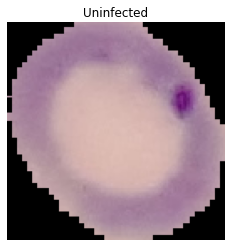

./test/C39P4thinF_original_IMG_20150622_105102_cell_84.png


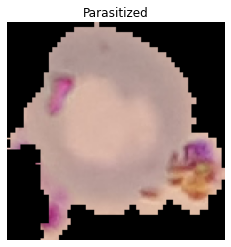

./test/C39P4thinF_original_IMG_20150622_105102_cell_104.png


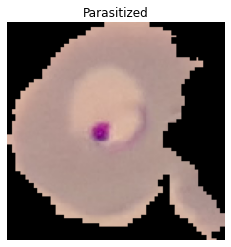

./test/C5NThinF_IMG_20150609_122108_cell_163.png


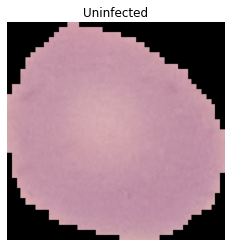

./test/C3thin_original_IMG_20150608_163029_cell_220.png


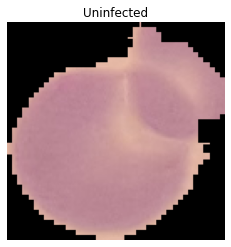

./test/C5NThinF_IMG_20150609_122227_cell_72.png


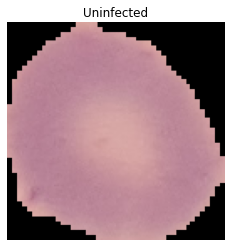

./test/C2NThinF_IMG_20150604_115238_cell_126.png


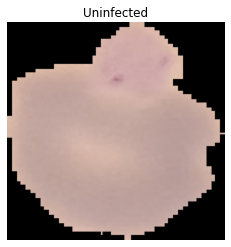

./test/C4thin_original_IMG_20150608_170016_cell_31.png


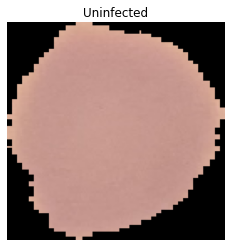

./test/C39P4thinF_original_IMG_20150622_105253_cell_92.png


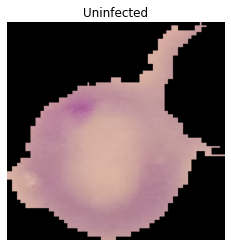

./test/C39P4thinF_original_IMG_20150622_105102_cell_100.png


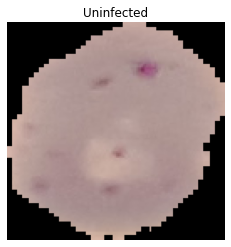

./test/C39P4thinF_original_IMG_20150622_105253_cell_102.png


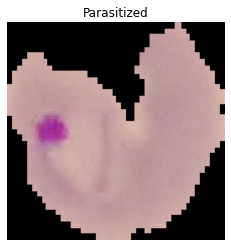

./test/C5NThinF_IMG_20150609_122034_cell_171.png


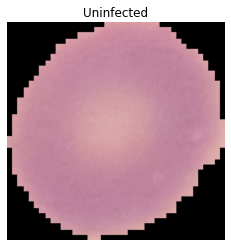

./test/C39P4thinF_original_IMG_20150622_105253_cell_104.png


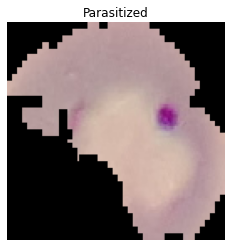

./test/C39P4thinF_original_IMG_20150622_105803_cell_98.png


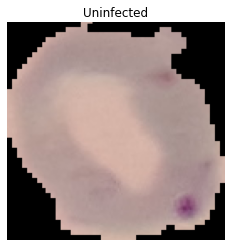

./test/C3thin_original_IMG_20150608_163002_cell_195.png


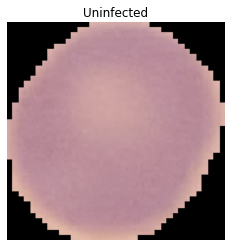

./test/C39P4thinF_original_IMG_20150622_105253_cell_91.png


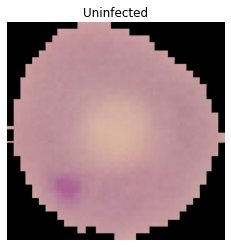

./test/C5NThinF_IMG_20150609_122020_cell_48.png


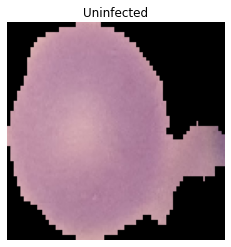

./test/C3thin_original_IMG_20150608_162835_cell_101.png


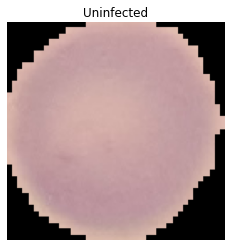

./test/C3thin_original_IMG_20150608_162835_cell_8.png


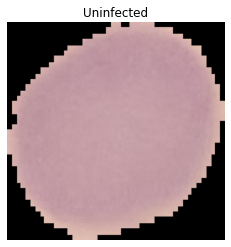

./test/C5NThinF_IMG_20150609_122020_cell_37.png


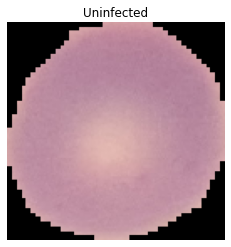

./test/C39P4thinF_original_IMG_20150622_110115_cell_130.png


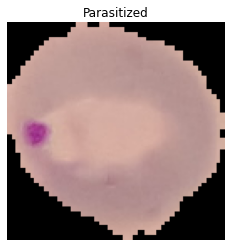

./test/C4thin_original_IMG_20150608_165540_cell_50.png


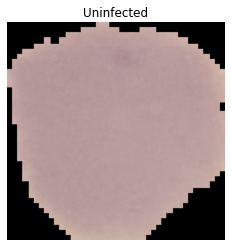

./test/C39P4thinF_original_IMG_20150622_110115_cell_128.png


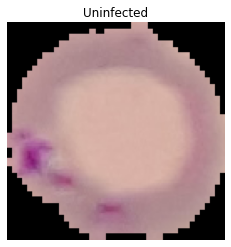

./test/C39P4thinF_original_IMG_20150622_105335_cell_23.png


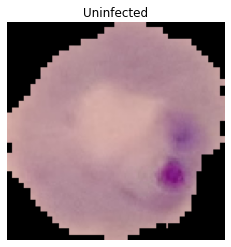

./test/C3thin_original_IMG_20150608_163029_cell_57.png


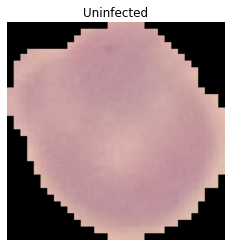

./test/C39P4thinF_original_IMG_20150622_110352_cell_113.png


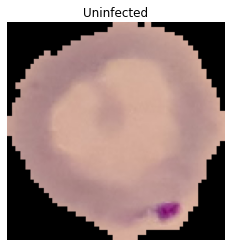

./test/C2NThinF_IMG_20150604_114815_cell_235.png


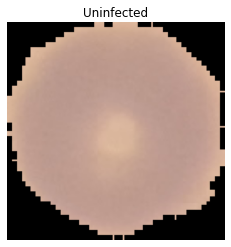

./test/C39P4thinF_original_IMG_20150622_110352_cell_94.png


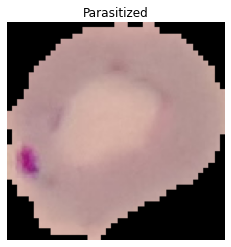

./test/C39P4thinF_original_IMG_20150622_105253_cell_97.png


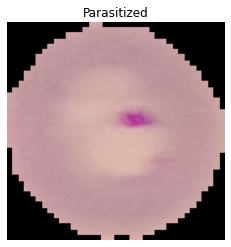

./test/C2NThinF_IMG_20150604_114815_cell_242.png


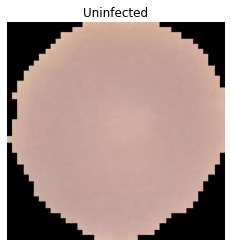

In [33]:
last_run_preds_int8 = all_preds_int8[0]
last_run_preds_int8 = tf.make_tensor_proto(last_run_preds_int8)
last_run_preds_int8 = tf.make_ndarray(last_run_preds_int8)
display_prediction_info(last_run_preds_int8, images)